In [1]:
from core import *
from utils import *
from diagnostics import *
from fields import *
from constants import *
from distributions import *

from scipy import constants as sp
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from numba import njit

import cProfile

def plot_traj(history):
    fig = plt.figure(figsize = plt.figaspect(1) * 7)
    ax = fig.add_subplot(111, projection='3d')

    for i in range(trials):
        pos = history[i, :, 0]
        ax.plot(pos[:, 0], pos[:, 1], pos[:, 2])

    plt.show()
    
def plot_gca(gca):
    fig = plt.figure(figsize = plt.figaspect(1) * 7)
    ax = fig.add_subplot(111, projection='3d')

    for i in range(trials):
        pos = gca[i, :, :]
        ax.plot(pos[:, 0], pos[:, 1], pos[:, 2])

    plt.show()
    
def to_percent(observed, actual):
    return abs((observed - actual) / actual) * 100

Load IGRF coefficients ...


In [2]:
e_field = zero_field()
b_field = t89(0)
solve   = solver(relativistic_boris(e_field, b_field))

In [ ]:
T      = 1           # Total time (in seconds)
dt     = 1e-4        # Simulation time step
trials = 1           # Number of runs
steps  = int(T / dt) # Number of steps per run

history, intrinsic = populate(trials,
                              steps,
                              e_field,
                              b_field,
                              uniform_partial_ring(11 * Re, 12 * Re, 5 * np.pi / 6, 7 * np.pi / 6),
                              delta(1e7),
                              delta(np.pi / 8),
                              uniform(0, 2 * np.pi)
                             )

solve(history, intrinsic, dt)

plot_traj(history)

In [ ]:
v_par = np.linalg.norm(velocity_par(history), axis=2)
pa = pitch_angle(history)
p_mag = position_mag(history)
eq_pa = eq_pitch_angle_from_moment(history, intrinsic)
b_magn = b_mag(history)
indices = np.arange(0, steps) * dt

plt.figure(figsize=(15, 10))

plt.subplot(221)
plt.plot(indices, v_par[0, :])
plt.xlabel('Time (s)')
plt.ylabel('Parallel velocity (m/s)')
plt.xlim([0, 1])
plt.grid()

plt.subplot(222)
plt.plot(indices, pa[0, :])
plt.xlabel('Time (s)')
plt.ylabel('Pitch angle (degrees)')
plt.xlim([0, 1])
plt.grid()

plt.subplot(223)
plt.plot(indices, eq_pa[0, :])
plt.xlabel('Time (s)')
plt.ylabel('Equatorial pitch angle (degrees)')
plt.xlim([0, 1])
plt.grid()

plt.subplot(224)
plt.plot(indices, b_magn[0, :])
plt.xlabel('Time (s)')
plt.ylabel('Magnetic field strength (Tesla)')
plt.xlim([0, 1])
plt.grid()

plt.show()

In [5]:
@njit
def b_mag_along_field_line(field, rr):
    steps = len(rr[:, 0])
    
    field_str = np.zeros(steps)
    
    for i in range(steps):
        field_str[i] = np.linalg.norm(field(rr[i]))
        
    return field_str

@njit
def b_along_field_line(field, rr):
    steps = len(rr[:, 0])
    
    field_vec = np.zeros((steps, 3))
    
    for i in range(steps):
        field_vec[i] = field(rr[i])
        
    return field_vec

@njit
def rr_mag(rr):
    steps = len(rr[:, 0])
    
    rrm = np.zeros(steps)
    
    for i in range(steps):
        rrm[i] = np.dot(rr[i], rr[i])
        
    return rrm

In [27]:
b_field = t89(1)

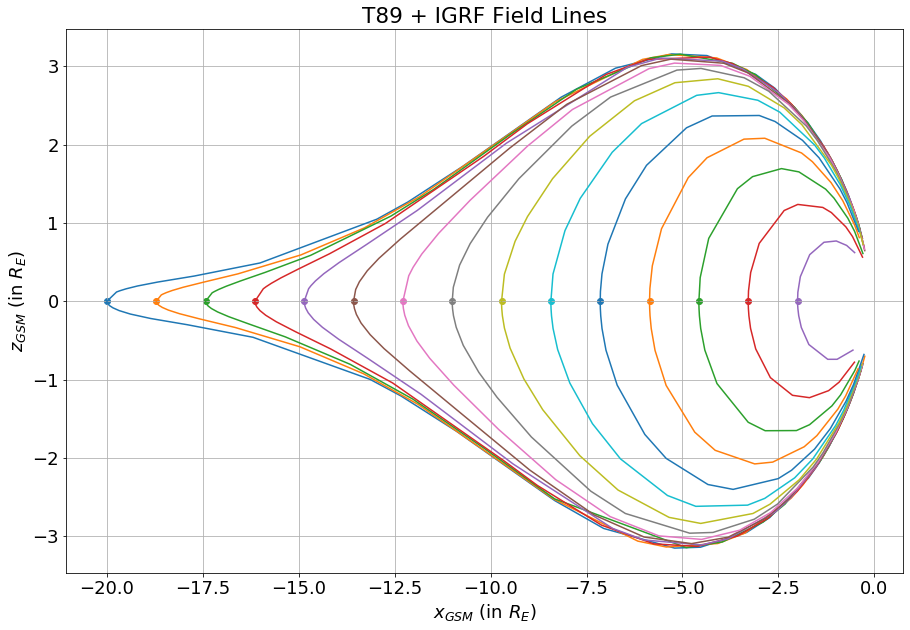

In [32]:
from field_utils import *

plt.figure(figsize=(15, 10))
plt.rcParams.update({'font.size': 18})

for i, x in enumerate(np.linspace(-20 * Re, -2 * Re, 15)):
    rr = field_line(b_field, np.array([x, 0, 0]), 1e2)
    r_min = field_reversal(b_field, rr)
    
    plt.plot(rr[:, 0] / Re, rr[:, 2] / Re)
    plt.scatter(r_min[0] / Re, r_min[2] / Re)
    
plt.grid()
plt.xlabel('$x_{GSM}$ (in $R_E$)')
plt.ylabel('$z_{GSM}$ (in $R_E$)')
plt.title('T89 + IGRF Field Lines')
plt.show()

In [142]:
@njit
def b_along_path(field, rr):
    steps = len(rr[:, 0])
    field_vec = np.zeros((steps, 3))
    field_mag = np.zeros(steps)
    field_rad_mag = np.zeros(steps)
    
    for i in range(steps):
        vec = field(rr[i])
        
        field_vec[i] = vec
        field_mag[i] = np.linalg.norm(vec)
        field_rad_mag[i] = np.sqrt(vec[0]**2 + vec[1]**2)
        
    return field_vec, field_mag, field_rad_mag


@njit
def field_reversal(field, rr):
    b_vec, b_mag, b_rad_mag = b_along_path(field, rr)
    return rr[b_rad_mag.argmin()]


@njit
def mirror_point(field, rr, eq_pa):
    b_vec, b_mag, b_rad_mag = b_along_path(field, rr)
    b_max = b_mag[b_rad_mag.argmin()] / np.sin(np.radians(eq_pa))**2
    
    ind = np.abs(b_mag - b_max).argmin()
    x = np.interp(b_max, b_mag[ind - 1:ind + 1], rr[ind - 1:ind + 1, 0])
    y = np.interp(b_max, b_mag[ind - 1:ind + 1], rr[ind - 1:ind + 1, 1])
    z = np.interp(b_max, b_mag[ind - 1:ind + 1], rr[ind - 1:ind + 1, 2])
    
    interp_b_mag = np.linalg.norm(field(np.array([x, y, z])))
    
    if abs(interp_b_mag - b_max) <= abs(b_mag[ind] - b_max):
        return np.array([x, y, z])
    else:
        return rr[ind]
    
    return np.array([x, y, z])

4.8695643816089686e-08
4.769609466876558e-08


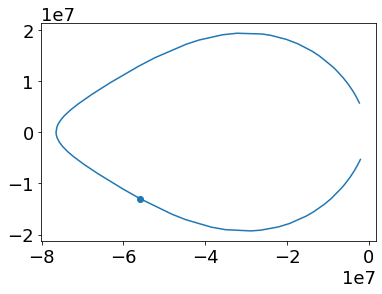

In [123]:
rr = field_line(b_field, np.array([-12 * Re, 0, 0]), 1e1)

plt.plot(rr[:, 0], rr[:, 2])

mp = mirror_point(b_field, rr, 20)
print(np.linalg.norm(b_field(mp)))

plt.scatter(mp[0], mp[2])

In [108]:
e_field = zero_field()
b_field = t89(1)
solve   = solver(relativistic_boris(e_field, b_field))

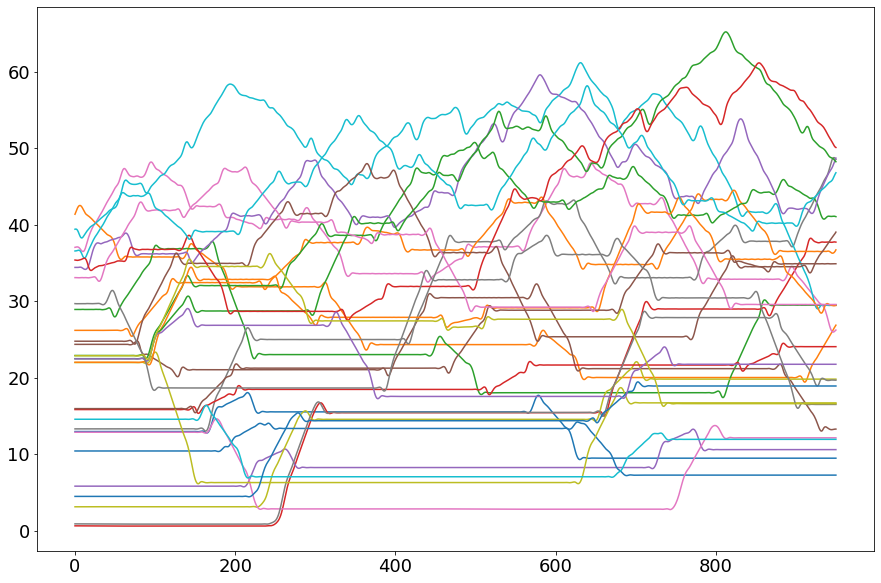

In [149]:
T      = 1           # Total time (in seconds)
dt     = 1e-3        # Simulation time step
trials = 30          # Number of runs
steps  = int(T / dt) # Number of steps per run

rr = field_line(b_field, np.array([-12 * Re, 0, 0]), 1e2) 

def uniform_eq_pa(field, rr, min_val, max_val):
    uni = uniform(min_val, max_val)
    
    def sample():
        return mirror_point(field, rr, uni()[0])
    
    return sample

history, intrinsic = populate(trials,
                              steps,
                              e_field,
                              b_field,
                              uniform_eq_pa(b_field, rr, 0, 40),
                              delta(1e6),
                              delta(np.pi / 2),
                              uniform(0, 2 * np.pi)
                             )

solve(history, intrinsic, dt)

def running_mean(x, t):
    N = int(t / dt)
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

eqpas = eq_pitch_angle_from_moment(history, intrinsic)
plt.figure(figsize=(15, 10))
for i in range(trials):
    plt.plot(running_mean(eqpas[i], 0.05))

[6, 169, 191, 447, 504, 600]


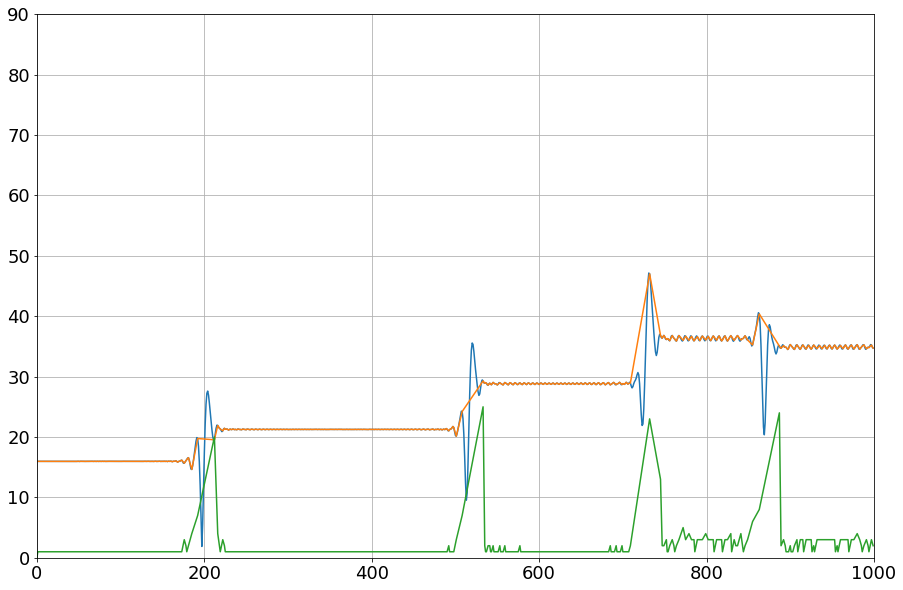

In [346]:
plt.figure(figsize=(15, 10))

i = 25
rms = eqpas[i]
centered = np.diff(rms, prepend=rms[0])
within_thresh = np.argwhere(np.abs(centered) <= 0.2)[:, 0]

#(within_thresh)

plt.plot(rms)
plt.plot(within_thresh, rms[within_thresh])

contiguous = np.diff(within_thresh, prepend=within_thresh[0])
plt.plot(within_thresh, contiguous)

#plt.plot(rms)
#plt.plot(centered)
#plt.plot(rms[within_thresh])
#plt.plot(within_thresh)

endpoints = []

k0 = 0
k1 = 0
pad = 5

#plt.plot(contiguous)
for i in range(len(contiguous)):
    k1 += 1
    if contiguous[i] == 1:
        continue
    else:
        if k1 >= 50:
            endpoints.append(k0 + pad)
            endpoints.append(k0 + k1 - 1 - pad)
        k0 += k1
        k1 = 0
        
print(endpoints)
for i in range(int(len(endpoints) / 2)):
    indices = within_thresh[endpoints[i]:endpoints[i + 1]]
    #plt.hlines(np.mean(rms[within_thresh][indices]), indices[0], indices[-1])

#plt.plot(contiguous)
#plt.plot(rms[within_thresh])
#print(endpoints)

#plt.plot(within_thresh)
#plt.plot(rms[within_thresh])

#plt.hlines([1, 0, -1], 0, 1000, linestyle='--')
#plt.vlines(endpoints, 0, 20)
plt.ylim([0, 90])
plt.xlim([0, 1000])
plt.grid()
plt.show()